In [1]:
#################################################
################  Import things #################
#################################################

import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import lsmr
import jax
import jax.numpy as jnp
import jax.experimental as jexp
from jax.experimental import sparse as jexps
import networkx as nx
from math import exp
from functools import partial
import timeit
import random
import copy
import matplotlib.pyplot as plt
import pickle

from scipy.stats import dirichlet
import dirichlet as dirichlet_mle #https://github.com/ericsuh/dirichlet

## here are the user-defined functions and classes
from MarkovComputations import *

In [48]:
def compute_activation(aff_mat, dist_vec, non_sat = False, safe_val=1e-2):
    """
    Compute the activation given an affinity matrix and a distribution vector.
    If invert is True, invert the affinity matrix as in build_activation_arrays.
    """
    if non_sat:
        aff_mat = aff_mat - np.min(aff_mat) + safe_val
        aff_mat = 1 / aff_mat
        numerator = np.dot(aff_mat, dist_vec)
        denominator = 1 + numerator
    else:
        numerator = np.dot(aff_mat, dist_vec)
        denominator = 1
    return numerator / denominator

def build_activation_arrays_with_sampling_mle(z_score_mat, group_indices, group_alphas, n_samples):
    aff_mat = z_score_mat
    activation_arrays = {}
    for group in group_indices:
        activation_array = np.zeros((aff_mat.shape[0], n_samples))
        for i in range(n_samples):
            samp = dirichlet.rvs(group_alphas[group], size = 1)[0]
            activation_array[:, i] = compute_activation(aff_mat, samp)
        activation_arrays[group] = activation_array
    return activation_arrays

def center_and_scale_activation_arrays(activation_arrays, scale_fac = 10):
    # Concatenate all arrays to compute global mean and std
    all_data = np.concatenate([activation_arrays[group].T for group in activation_arrays], axis=0)
    global_mean = np.array([np.mean(all_data, axis=0)])
    global_std = np.array([np.std(all_data, axis=0)])
    for group in activation_arrays:
        activation_arrays[group] = scale_fac * (activation_arrays[group] - global_mean.T) / global_std.T
    return activation_arrays

# def convert_activation_arrays_to_input_data(activation_arrays):
#     input_data = InputData(n_classes, data_list)
#     return input_data

def load_and_process_data(data_path, n_samples=20000, scale_fac=10):
    """
    Load experimental data and process it to create scaled activation arrays and input data
    
    Parameters:
    -----------
    data_path : str
        Path to the pickle file containing experimental data
    n_samples : int, optional
        Number of samples to generate (default 200)
    scale_fac : float, optional
        Scale factor for centering and scaling activation arrays (default 10)
        
    Returns:
    --------
    tuple
        (activation_arrays, input_data) where activation_arrays is the scaled arrays
        and input_data is the processed InputData object
    """
    with open(data_path, 'rb') as f:
        exp_data = pickle.load(f)

    group_alphas = exp_data['group_alphas']
    z_score_mat = exp_data['z_score_mat']
    group_indices = exp_data['group_indices']

    activation_arrays = build_activation_arrays_with_sampling_mle(z_score_mat, group_indices, group_alphas, n_samples)
    activation_arrays = center_and_scale_activation_arrays(activation_arrays, scale_fac=scale_fac)

    n_classes = len(activation_arrays.keys())
    data_list = []
    for group in activation_arrays.keys():
        group_data = []
        for i in range(np.shape(activation_arrays[group])[1]):
            group_data.append(activation_arrays[group][:,i])
        data_list.append(group_data)

    input_data = InputData(n_classes, data_list)
    
    return activation_arrays, input_data

# activation_arrays, input_data = load_and_process_data('/Users/csfloyd/Dropbox/Projects/MarkovComputation/GlycanData/Bacteria_LlpA_SSL3.pkl', n_samples=20000, scale_fac=10)

activation_arrays, input_data = load_and_process_data('/Users/csfloyd/Dropbox/Projects/MarkovComputation/GlycanData/Bacteria_MuHV1gpm153_ECBirAH6.pkl', n_samples=20000, scale_fac=15)


In [57]:
# Compute standard deviations across all groups
all_x = np.concatenate([arr[0,:] for arr in activation_arrays.values()])
all_y = np.concatenate([arr[1,:] for arr in activation_arrays.values()])
std_x = np.std(all_x)
std_y = np.std(all_y)
print(f"Standard deviation - x: {std_x:.3f}, y: {std_y:.3f}")


Standard deviation - x: 1.000, y: 1.000


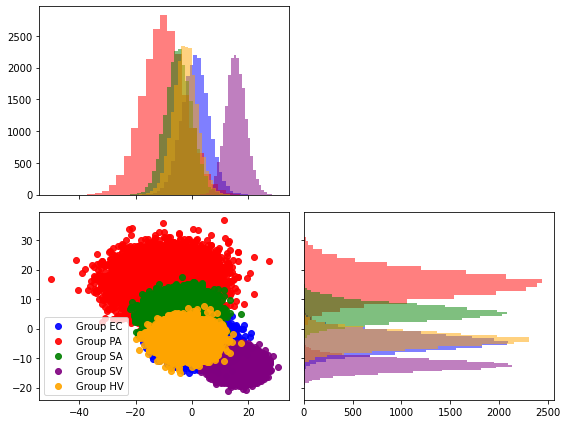

In [68]:
# Create a figure with 3 subplots - main scatter plot and two histograms
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 2)
ax_scatter = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0])
ax_histy = fig.add_subplot(gs[1, 1])

colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']  # Add more colors if needed

# Plot scatter and histograms for each group
for i, (group, activation_array) in enumerate(activation_arrays.items()):
    # Scatter plot
    ax_scatter.scatter(activation_array[0,:], activation_array[1,:], 
                      color=colors[i], label=f'Group {group}', alpha=0.9)
    
    # X-axis histogram
    ax_histx.hist(activation_array[0,:], bins=30, color=colors[i], 
                  alpha=0.5, label=f'Group {group}')
    
    # Y-axis histogram
    ax_histy.hist(activation_array[1,:], bins=30, orientation='horizontal',
                  color=colors[i], alpha=0.5)

# Adjust layouts and labels
ax_histx.set_xticklabels([])
ax_histy.set_yticklabels([])

# Add legend to main scatter plot
ax_scatter.legend()

# Tight layout to prevent overlap
plt.tight_layout()

In [5]:
### Define parameters of classification
M = 4 # how many edges affected per input dimension
n_classes = 5 # D, how many classes, placeholder
input_dim = 1 # D, how many components of each input data

### Define parameters of graph object and initial weights
n_nodes = 20 # assuming a complete graph
E_range = 0 # range of uniform distribution for Ej, etc.
B_range = 0
F_range = 0


############################################################
################  Initialize weight_matrix #################
############################################################

## create graph
g = nx.complete_graph(n_nodes) # assuming a complete graph for now - easy to change
n_edges = len(list(g.edges())) 

## get input and output inds
rand_bool = True
output_inds = get_output_inds(n_nodes, n_classes, rand_bool)
input_inds = get_input_inds(n_edges, input_dim, M, rand_bool)

## initialize first edge rates
Ej_list, Bij_list, Fij_list = random_initial_parameters(E_range, B_range, F_range, n_nodes, n_edges)

# Create WeightMatrix object
weight_matrix = WeightMatrix(g, Ej_list, Bij_list, Fij_list)


A_fac = 0
b_fac = 0

############################################################
################  Load classification data #################
############################################################

n_samples = 20000
activation_arrays, input_data = load_and_process_data('/Users/csfloyd/Dropbox/Projects/MarkovComputation/GlycanData/Bacteria_LlpA_SSL3.pkl', n_samples=20000, scale_fac=7.5)


L = 1
external_input_dim = input_dim
external_output_dim = n_classes

internal_input_dims = []
internal_output_dims = []
M_vals = [M]


external_input_inds = get_input_inds(n_edges, input_dim, M)

weight_matrix_list = [WeightMatrix(g, Ej_list, Bij_list, Fij_list) for l in range(L)]
stacked_weight_matrices = StackedWeightMatrices(weight_matrix_list, 
                                                [external_input_dim, external_output_dim],
                                                [internal_input_dims, internal_output_dims],
                                                M_vals, A_fac, b_fac, rand_bool)





In [6]:
################################################
################  Run training #################
################################################

stacked_weight_matrix_orig = copy.deepcopy(stacked_weight_matrices)  # save original rate matrix 

error_list = []  # track errors during training
accuracy_list = []
accuracy_stride = 2

n_training_iters = 200  # how many training steps to take
batch_size = 10          # set your batch size
eta_markov = 5e-2

adam_beta1 = 0.9
adam_beta2 = 0.999
adam_epsilon = 1e-8

for training_iter in range(n_training_iters):

    stacked_weight_matrices.zero_gradients()  # Zero the accumulators at the start of each batch

    for _ in range(batch_size):
        class_number = random.randrange(n_classes)  # draw a random class label to present

        inputs = input_data.get_next_training_sample(class_number)

        # Compute gradients for this sample
        markov_grads = stacked_weight_matrices.compute_gradients_single(inputs, class_number)
        # Accumulate gradients
        stacked_weight_matrices.accumulate_gradients(markov_grads)

        # Optionally, you can compute and store the error for this sample
        ss_list, inputs_list = stacked_weight_matrices.compute_stacked_ss_on_inputs(inputs)
        error_list.append(
            np.linalg.norm(
                compute_error(ss_list[-1], input_data, class_number, stacked_weight_matrices.external_output_inds)
            )
        )

    #print(stacked_weight_matrices.markov_grad_accum['theta'][0])
    # After accumulating over the batch, apply the Adam optimizer update
    stacked_weight_matrices.apply_adam_gradients(
        batch_size, eta_markov, adam_beta1, adam_beta2, adam_epsilon
    )

     # Compute accuracy using the perceptron-based network
    if (training_iter % accuracy_stride == 0):
        print(training_iter)
        accuracy_list.append(
            evaluate_accuracy(stacked_weight_matrices, input_data, n_classes, 10)
        )
    

   
    

0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
144
146
148
150
152
154
156
158
160
162
164
166
168
170
172
174
176
178
180
182
184
186
188
190
192
194
196
198


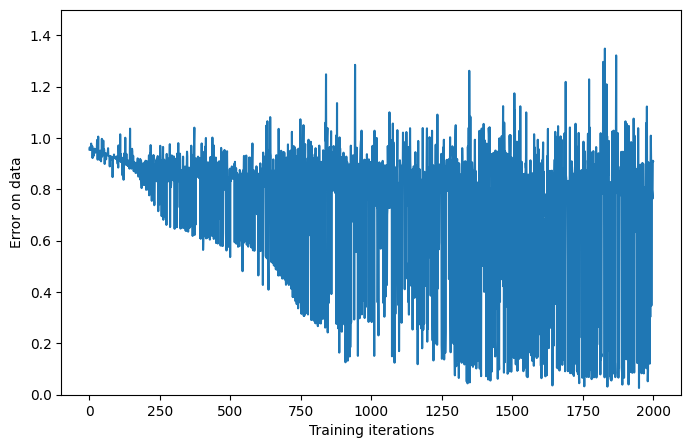

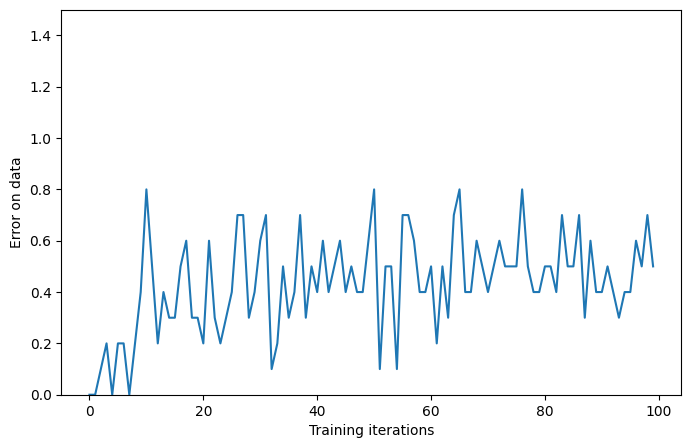

In [7]:
################################################
################  Plot results #################
################################################

### plot the error
plt.figure(figsize=(8, 5))
plt.plot(error_list)
plt.xlabel("Training iterations")
plt.ylabel("Error on data")
plt.ylim(0,1.5)
#plt.xlim(0,n_training_iters)
plt.show()


### plot the error
plt.figure(figsize=(8, 5))
plt.plot(accuracy_list)
plt.xlabel("Training iterations")
plt.ylabel("Error on data")
plt.ylim(0,1.5)
#plt.xlim(0,n_training_iters)
plt.show()




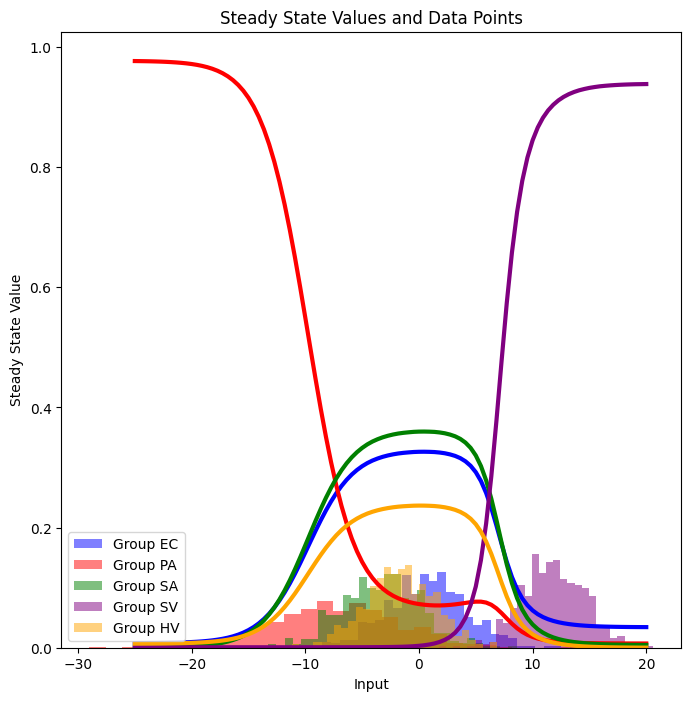

In [9]:
# Define a 1D grid of input values
x_values = np.linspace(-25, 20, 100)  # Adjust range as needed

# Initialize array to store steady state values
ss_values = np.zeros((len(x_values), len(stacked_weight_matrices.external_output_inds)))

# Compute steady states for each point in the grid
for i, x in enumerate(x_values):
    ss_list, inputs_list = stacked_weight_matrices.compute_stacked_ss_on_inputs([x])
    ss_at_outputs = [ss_list[-1][out] for out in stacked_weight_matrices.external_output_inds]
    ss_values[i,:] = ss_at_outputs
        
# Create plot
plt.figure(figsize=(8, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']  # Add more colors if needed

# Plot lines and scatter for each group/output
for i, ((group, activation_array), output_ind) in enumerate(zip(activation_arrays.items(), stacked_weight_matrices.external_output_inds)):
    # Line plot of steady states
    plt.plot(x_values, ss_values[:,i], color=colors[i], alpha=1, linewidth=3)
    
    # Histogram plot for corresponding group
    plt.hist(activation_array[0,:500], bins=30, color=colors[i], label=f'Group {group}', 
             alpha=0.5, density=True, bottom=0)

plt.xlabel("Input")
plt.ylabel("Steady State Value")
plt.title("Steady State Values and Data Points")
plt.legend()
plt.show()

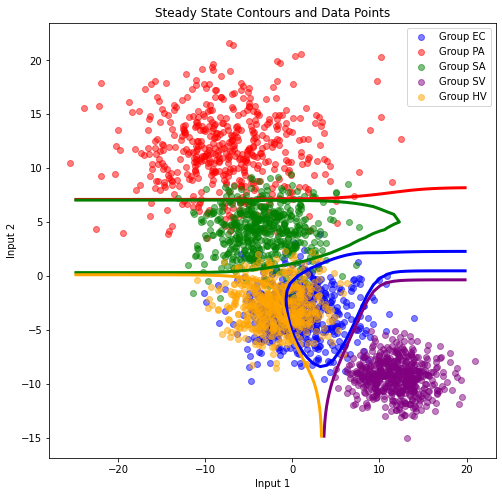

In [133]:
# Define a 2D grid of input values
x1_values = np.linspace(-25, 20, 60)  # Adjust range as needed
x2_values = np.linspace(-15, 20, 50)  # Adjust range as needed
X1, X2 = np.meshgrid(x1_values, x2_values)

# Initialize array to store steady state values
ss_values = np.zeros((len(x1_values), len(x2_values), len(stacked_weight_matrices.external_output_inds)))

# Compute steady states for each point in the grid
for i, x1 in enumerate(x1_values):
    for j, x2 in enumerate(x2_values):
        ss_list, inputs_list = stacked_weight_matrices.compute_stacked_ss_on_inputs([x1, x2])
        ss_at_outputs = [ss_list[-1][out] for out in stacked_weight_matrices.external_output_inds]
        ss_values[i,j,:] = ss_at_outputs
        
        # Create contour plots
plt.figure(figsize=(8, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']  # Add more colors if needed

# Plot contours and scatter for each group/output
for i, ((group, activation_array), output_ind) in enumerate(zip(activation_arrays.items(), stacked_weight_matrices.external_output_inds)):
    # Contour plot
    plt.contour(X1, X2, ss_values[:,:,i].T, levels=[0.5], colors=colors[i], alpha=1, linewidths=3)
    
    # Scatter plot for corresponding group
    plt.scatter(activation_array[0,:500], activation_array[1,:500], 
               color=colors[i], label=f'Group {group}', alpha=0.5)

#plt.colorbar(label='Steady State Value')
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.title("Steady State Contours and Data Points")
plt.legend()
plt.show()

In [64]:
### Define parameters of classification
M = 4 # how many edges affected per input dimension
n_classes = 5 # D, how many classes, placeholder
input_dim = 1 # D, how many components of each input data

### Define parameters of graph object and initial weights
n_nodes = 15 # assuming a complete graph
E_range = 0 # range of uniform distribution for Ej, etc.
B_range = 0
F_range = 0

seed = 15
np.random.seed(seed)
random.seed(seed)


############################################################
################  Initialize weight_matrix #################
############################################################

## create graph
g = nx.complete_graph(n_nodes) # assuming a complete graph for now - easy to change
n_edges = len(list(g.edges())) 

## get input and output inds
rand_bool = True
output_inds = get_output_inds(n_nodes, n_classes, rand_bool)
input_inds = get_input_inds(n_edges, input_dim, M, rand_bool)

## initialize first edge rates
Ej_list, Bij_list, Fij_list = random_initial_parameters(E_range, B_range, F_range, n_nodes, n_edges)

# Create WeightMatrix object
weight_matrix = WeightMatrix(g, Ej_list, Bij_list, Fij_list)


A_fac = -5
b_fac = 1

############################################################
################  Load classification data #################
############################################################

activation_arrays, input_data = load_and_process_data('/Users/csfloyd/Dropbox/Projects/MarkovComputation/GlycanData/Bacteria_MuHV1gpm153_ECBirAH6.pkl', n_samples=20000, scale_fac=10)


L = 1
external_input_dim = input_dim
external_output_dim = n_classes

internal_input_dims = []
internal_output_dims = []
M_vals = [M]


external_input_inds = get_input_inds(n_edges, input_dim, M)

weight_matrix_list = [WeightMatrix(g, Ej_list, Bij_list, Fij_list) for l in range(L)]
stacked_weight_matrices = StackedWeightMatrices(weight_matrix_list, 
                                                [external_input_dim, external_output_dim],
                                                [internal_input_dims, internal_output_dims],
                                                M_vals, A_fac, b_fac, rand_bool)



mi_list = train_mi_conjugate_gradient(
    stacked_weight_matrices,
    input_data,
    n_nodes,
    n_classes,
    n_samples=100,
    n_epochs=120,
    step_size=2.5e0,
    tol=1e-6,
    verbose=False
)

Training complete.


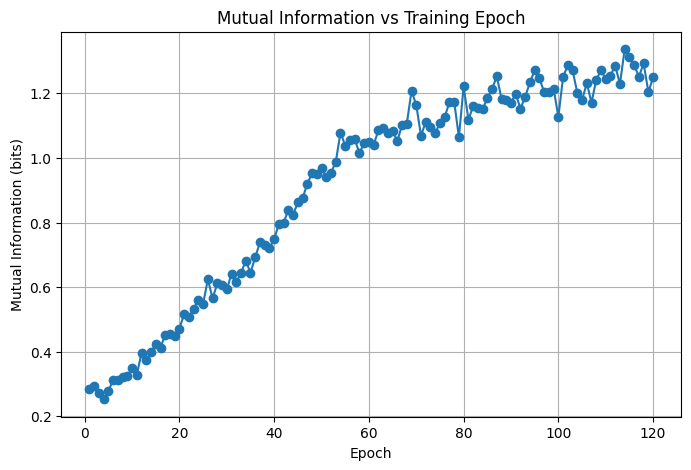

In [65]:
# Plot the mutual information over training epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(mi_list) + 1), mi_list, '-o')
plt.xlabel('Epoch')
plt.ylabel('Mutual Information (bits)')
plt.title('Mutual Information vs Training Epoch')
plt.grid(True)
plt.show()



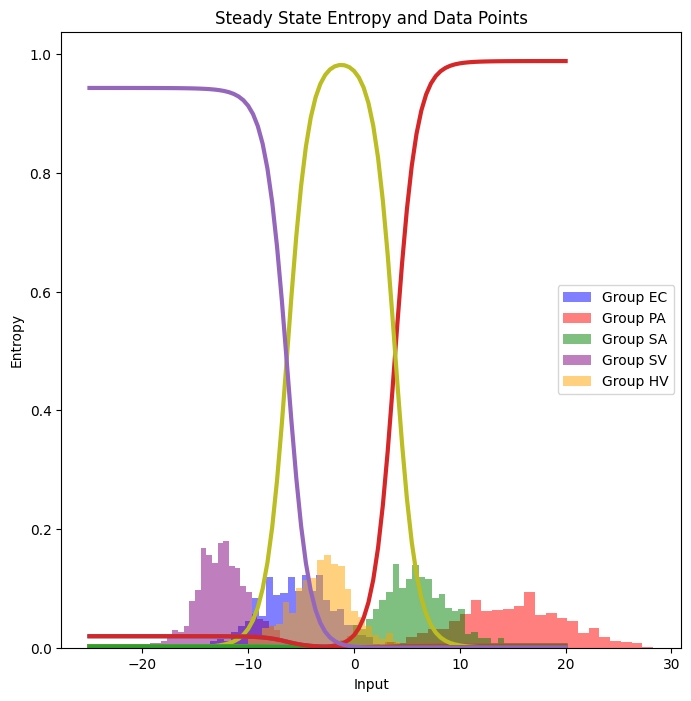

In [66]:
# Define a 1D grid of input values
x_values = np.linspace(-25, 20, 100)  # Adjust range as needed

def compute_entropy(ss_list):
    """
    Compute the entropy of the steady state distribution.
    """
    return -np.sum(ss_list * np.log(ss_list))   

node_outs = range(n_nodes)
ss_values = np.zeros((len(x_values), len(node_outs)))
# Compute steady states for each point in the grid
for i, x in enumerate(x_values):
    ss_list, inputs_list = stacked_weight_matrices.compute_stacked_ss_on_inputs([x])
    ss_at_outputs = [ss_list[-1][out] for out in node_outs]
    ss_values[i,:] = ss_at_outputs
        

# Initialize array to store steady state values
marginal_ss = stacked_weight_matrices.compute_marginal_distribution(input_data, n_nodes, n_classes, n_samples=1000)
mi_density_values = np.zeros(len(x_values))

# Compute steady states for each point in the grid
for i, x in enumerate(x_values):
    ss_list, inputs_list = stacked_weight_matrices.compute_stacked_ss_on_inputs([x])
    #mi_density_values[i] = stacked_weight_matrices.compute_mi_density(ss_list[-1], marginal_ss)
    mi_density_values[i] = compute_entropy(ss_list[-1])
        
# Create line plot
plt.figure(figsize=(8, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']  # Add more colors if needed

# Plot scatter for each group/output
for i, ((group, activation_array), output_ind) in enumerate(zip(activation_arrays.items(), stacked_weight_matrices.external_output_inds)):
    
    # Histogram plot for corresponding group
    plt.hist(activation_array[0,:500], bins=30, color=colors[i], 
            label=f'Group {group}', alpha=0.5, density=True)
    
for i in node_outs:
    # Plot lines and scatter for each group/output
    plt.plot(x_values, ss_values[:,i], alpha=1, linewidth=3)

# Plot entropy values
# plt.plot(x_values, mi_density_values, 'k-', linewidth=3, alpha=1)

plt.xlabel("Input")
plt.ylabel("Entropy")
plt.title("Steady State Entropy and Data Points")
plt.legend()
plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [30]:
stacked_weight_matrices.external_output_inds

[5, 13, 12, 10, 7]

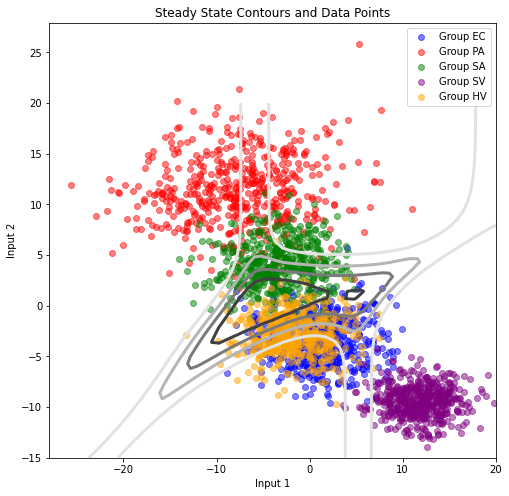

In [185]:
# Define a 2D grid of input values
x1_values = np.linspace(-25, 20, 60)  # Adjust range as needed
x2_values = np.linspace(-15, 20, 50)  # Adjust range as needed
X1, X2 = np.meshgrid(x1_values, x2_values)

def compute_entropy(ss_list):
    """
    Compute the entropy of the steady state distribution.
    """
    return -np.sum(ss_list * np.log(ss_list))   

# Initialize array to store steady state values
marginal_ss = stacked_weight_matrices.compute_marginal_distribution(input_data, n_nodes, n_classes, n_samples=1000)
mi_density_values = np.zeros((len(x1_values), len(x2_values)))

# Compute steady states for each point in the grid
for i, x1 in enumerate(x1_values):
    for j, x2 in enumerate(x2_values):
        ss_list, inputs_list = stacked_weight_matrices.compute_stacked_ss_on_inputs([x1, x2])
        #mi_density_values[i,j] = stacked_weight_matrices.compute_mi_density(ss_list[-1], marginal_ss)
        mi_density_values[i,j] = compute_entropy(ss_list[-1])
        
# Create contour plots
plt.figure(figsize=(8, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']  # Add more colors if needed

# Plot contours and scatter for each group/output
for i, ((group, activation_array), output_ind) in enumerate(zip(activation_arrays.items(), stacked_weight_matrices.external_output_inds)):
    
    # Scatter plot for corresponding group
    plt.scatter(activation_array[0,:500], activation_array[1,:500], 
               color=colors[i], label=f'Group {group}', alpha=0.5)
    
# Contour plot
plt.contour(X1, X2, mi_density_values.T, levels=5, cmap='Greys', alpha=1, linewidths=3)

#plt.colorbar(label='Steady State Value')
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.title("Steady State Contours and Data Points")
plt.legend()
plt.show()

In [183]:
np.max(mi_density_values)

1.1077393293380737

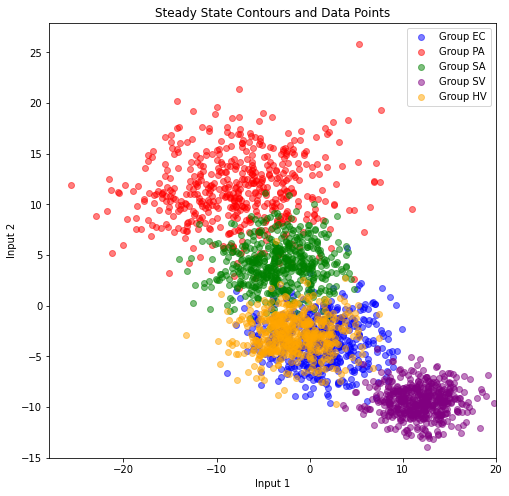

In [180]:
# Create contour plots
plt.figure(figsize=(8, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']  # Add more colors if needed

# Plot contours and scatter for each group/output
for i, ((group, activation_array), output_ind) in enumerate(zip(activation_arrays.items(), stacked_weight_matrices.external_output_inds)):
    
    # Scatter plot for corresponding group
    plt.scatter(activation_array[0,:500], activation_array[1,:500], 
               color=colors[i], label=f'Group {group}', alpha=0.5)
    
# Contour plot
plt.contour(X1, X2, mi_density_values.T, levels=[1.0], cmap='Greys', alpha=1, linewidths=3)

#plt.colorbar(label='Steady State Value')
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.title("Steady State Contours and Data Points")
plt.legend()
plt.show()

In [4]:
df = 0.2
inputs = [8]
inputs_df = [inputs[0] + df]

random.seed(15)
np.random.seed(15)
key = jax.random.PRNGKey(15)
input_data = InputData(n_classes, data_list)
marginal_ss = stacked_weight_matrices.compute_marginal_distribution(input_data, n_nodes, n_classes, n_samples = 1000)


mi_df = stacked_weight_matrices.compute_mi_density(inputs_df, marginal_ss)
mi_0 = stacked_weight_matrices.compute_mi_density(inputs, marginal_ss)
mi_d = stacked_weight_matrices.compute_mi_density_input_gradient(inputs, marginal_ss)
mi_app = mi_0 + mi_d[0] * df
print(mi_0)
print(mi_app)
print(mi_df)

0.71385926
0.751462
0.7508174


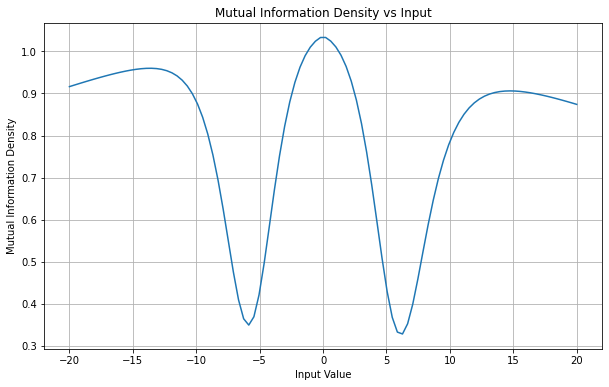

In [8]:
# Create range of input values to plot
input_range = np.linspace(-20, 20, 100)
mi_values = []

# Calculate MI density for each input value
marginal_ss = stacked_weight_matrices.compute_marginal_distribution(input_data, n_nodes, n_classes, n_samples = 1000)
ks = 0.01
for x in input_range:
    mi = stacked_weight_matrices.compute_mi_density([x], marginal_ss)
    reg_mi = mi  - ks * np.linalg.norm(x)
    mi_values.append(reg_mi)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(input_range, mi_values)
plt.xlabel('Input Value')
plt.ylabel('Mutual Information Density')
plt.title('Mutual Information Density vs Input')
plt.grid(True)
plt.show()


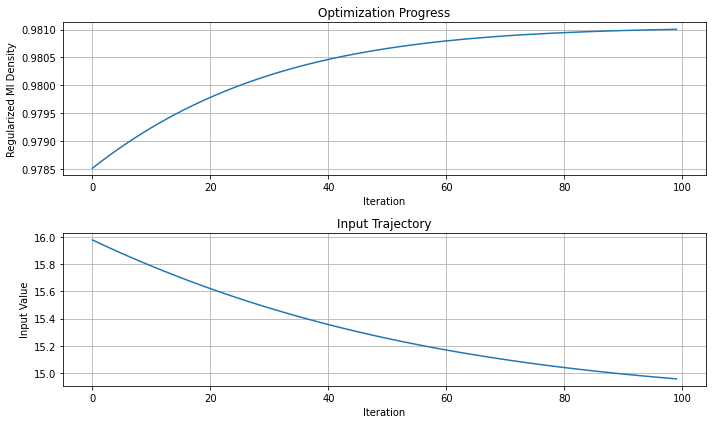

In [9]:
# Initialize random input
x = 16  # Start with random 1D input
learning_rate = 5
n_iterations = 100
ks = 0.01  # Regularization strength

mi_history = []
x_history = []

marginal_ss = stacked_weight_matrices.compute_marginal_distribution(input_data, n_nodes, n_classes, n_samples = 1000)
# Gradient ascent loop
for i in range(n_iterations):
    
    # Get current MI and gradient
    mi_0 = stacked_weight_matrices.compute_mi_density([x], marginal_ss)
    mi_grad = stacked_weight_matrices.compute_mi_density_input_gradient([x], marginal_ss)[0]
    
    # Add regularization
    reg_term = - ks * x / np.linalg.norm(x) # L1 regularization gradient
    total_grad = mi_grad + reg_term
    
    # Update x using gradient ascent
    x = x + learning_rate * total_grad
    
    # Store history
    mi_history.append(mi_0 - ks * np.linalg.norm(x))
    x_history.append(x)

# Plot optimization trajectory
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(mi_history)
plt.xlabel('Iteration')
plt.ylabel('Regularized MI Density')
plt.title('Optimization Progress')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(x_history)
plt.xlabel('Iteration')
plt.ylabel('Input Value')
plt.title('Input Trajectory')
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
input_data_mnist = load_and_format_mnist(10, 10, 2)




45.99379
29.872541
48.08847
30.556185
27.10561
27.406506
52.796696
38.099285
41.146515
49.725346


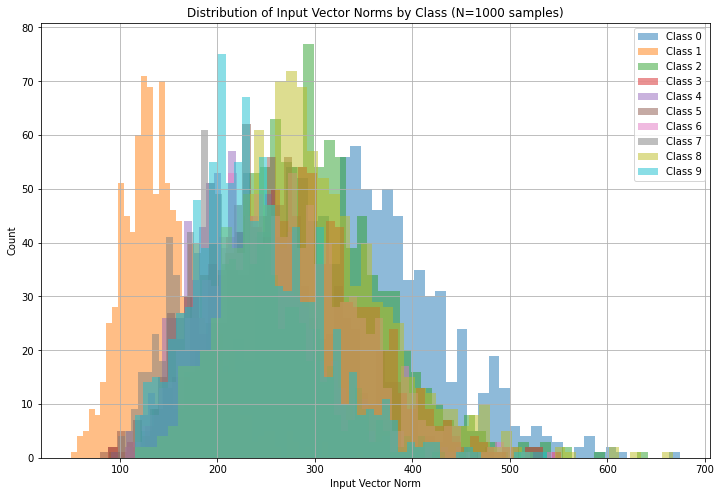

In [11]:
# Collect N samples of norms for each class
N = 1000
norms_by_class = {i: [] for i in range(10)}

for class_number in range(10):
    for _ in range(N):
        inputs = input_data_mnist.get_next_training_sample(class_number)
        norm = np.linalg.norm(inputs, ord=1)
        norms_by_class[class_number].append(norm)

# Plot histograms
plt.figure(figsize=(12, 8))
for class_number in range(10):
    plt.hist(norms_by_class[class_number], bins=50, alpha=0.5, label=f'Class {class_number}')

plt.xlabel('Input Vector Norm')
plt.ylabel('Count')
plt.title(f'Distribution of Input Vector Norms by Class (N={N} samples)')
plt.legend()
plt.grid(True)
plt.show()